# Notebook for analysis

In [ ]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
cores = list(mcolors.TABLEAU_COLORS.keys())
cores = [cor.split(':')[-1] for cor in cores]

sns.set_context('paper')
%matplotlib inline

def plot_params():
    plt.rc('text', usetex=True)
    plt.rc('font', size=13)
    plt.rc('xtick', labelsize=11)
    plt.rc('ytick', labelsize=11)
    plt.rc('axes', labelsize=14)
    plt.rc('legend', fontsize=8)
    plt.rc('lines', linewidth=1.0)
    plt.rcParams["axes.formatter.limits"] = (-3, 4)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plot_params()

# 1 Single neuron HH

desscribe the neuron's of hodgkin-huxley with their ionic currents.

the phase espaces and fixed points.

## 1 Single neuron HH

Describing the Hodgkin-Huxley neurons with their ionic currents and frequency of spike for each current external injected.

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt

os.chdir('PospischilEtAl2008')

import neuron as nrn # NEURON simulator
nrn.h.load_file("mosinit.hoc");
nrn.h.load_file("demo_PY_IBR.hoc");

Create Soma and insert mechanisms

In [ ]:
os.chdir('..')

In [ ]:
def create_soma(verbose=False):
    soma = nrn.h.Section(name='soma')
    soma.nseg = 1 #
    soma.diam = 96 #
    soma.L = 96 #			// so that area is about 29000 um2
    soma.cm = 1 #
    soma.Ra = 100 #		// geometry 

    if verbose:
        print("- Soma object:", soma)
        print("- Number of segments in the soma:", soma.nseg)
        print(f'- Diam: {soma.diam} | L: {soma.L} | cm: {soma.cm} | Ra: {soma.Ra}')
    return soma

def insert_mechanisms(soma, hh2=True, pas=True, im=True, it=True, il=True, return_mechs = False):
    if pas:
        soma.insert('pas')
        soma.e_pas = -85
        soma.g_pas = 1e-5 #		// idem TC cell

    if hh2:
        soma.insert('hh2'); #		// Hodgin-Huxley INa and IK 
        soma.ek = -100 #		// potassium reversal potential 
        soma.ena = 50 #			// sodium reversal potential 
        soma.vtraub_hh2 = -55 #	// Resting Vm, BJ was -55
        soma.gnabar_hh2 = 0.05 #	// McCormick=15 muS, thal was 0.09
        soma.gkbar_hh2 = 0.005 #	// spike duration of pyr cells
        celsius = 36
        v_init = -84
    
    if im:
        soma.insert('im'); #		// M current 
        taumax_im = 1000
        soma.gkbar_im = 3e-5 #		// specific to LTS pyr cell
    
    if it:
        soma.insert('it'); #// IT current 
        soma.cai = 2.4e-4 
        soma.cao = 2 
        #eca = 120 
        soma.gcabar_it = 0.0004 #// specific to LTS pyr cell

    if il:
        soma.insert('ical'); #// IL current (Reuveni et al. model, Nernst)
        soma.cai = 2.4e-4 
        soma.cao = 2 
        #soma.eca = 120 
        soma.gcabar_ical = 2.2e-4

        soma.insert('cad');  #		// calcium decay
        soma.depth_cad = 1 #		// McCormick= 0.1 um
        soma.taur_cad = 5 #		// McCormick=1 ms !!!
        soma.cainf_cad = 2.4e-4 #	// McCormick=0
        soma.kt_cad = 0 #		// no pump
        soma.depth_cad = 1 #		// McCormick= 0.1 um
    
    
    if return_mechs:
        return soma, hh2, pas, im, it, il
    else:
        return soma

In [ ]:
def simConfig(soma, t, amp, dur, delay, return_channels=False, verbose=False):
    # Simulations Config
    ## Runs:
    nrn.h.tstop = t
    nrn.h.dt = 0.01

    iclamp = nrn.h.IClamp(.5, sec=soma)
    iclamp.amp = amp # nA
    iclamp.delay = delay # ms
    iclamp.dur = dur # ms

    #### Vectors
    time = nrn.h.Vector()
    voltage = nrn.h.Vector()
    stim_current = nrn.h.Vector()

    time.record(nrn.h._ref_t)
    voltage.record(soma(.5)._ref_v);
    stim_current.record(iclamp._ref_i)

    mechs_ionic = {}
    for mechs, param_mechs in soma.psection()['density_mechs'].items():
        for key_mechs in param_mechs.keys():
            if key_mechs in ['m','n','h']:
                # find the mechanisms and create a vector to record data.
                mechs_ionic[f'{key_mechs}_{mechs}'] = nrn.h.Vector()

    channels = {}
    for channel, mechs in mechs_ionic.items():
        # for every ionic mechanism, get the attribute and record it
        ref_record = getattr(soma(.5), f'_ref_{channel}')
        channels[channel] = mechs.record(ref_record);
        if verbose:
            print(f'--> mechanism {mechs_ionic} of soma is recorded...')

    if verbose:
        print("- Simulation stop time: %f ms" % nrn.h.tstop)
        print("- Integration time step: %f ms" % nrn.h.dt)
        print("- Amplitude external current: %f nA" % iclamp.amp)
        print("- Duration external current: %f ms" % iclamp.dur)
        print("- Delay external current: %f ms" % iclamp.delay)
        print('- Return Channels: ', return_channels)
    nrn.h.run()
    
    if return_channels:
        return time, voltage, stim_current, channels
    else:
        return time, voltage, stim_current

In [ ]:
## Plots
def plot_tv(time_array, voltage_array, show=True, label=None, figsize=(10,3), color='black',
            ylabel='Membrane voltage (mV)', xyaxis=[2690, 3000, -85, 50], constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.figure(figsize=figsize)
    plt.plot(time_array, voltage_array, label=label, color=color, linewidth=0.7)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    plt.axis(xyaxis)
    if show:
        plt.show()

def plot_voltage_stim(time_array, voltage_array, stim_array, title, figsize=(10,3), save=False):
    #------------------------------------------------------------------------------
    # Plot figure
    #------------------------------------------------------------------------------
    f, (ax0, ax1) = plt.subplots(2,1, figsize=figsize, gridspec_kw = {'height_ratios':[3, 1]})
    sns.lineplot(x = time_array, y =voltage_array, color='black', ax=ax0)
    ax1.plot(time_array,stim_array, 'gray')

    ax0.set_ylim(-90, 55)
    ax0.set_ylabel('Voltage (mV)')
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.get_xaxis().set_visible(False)


    ax1.plot([0,0],[0,0.15],'k')
    ax1.text(20,stim_array.max()+0.03,f'{stim_array.max():.2f}nA',va='center')
    ax1.set_ylabel('Injected current (nA)')
    ax1.set_xlabel('Time (ms)')

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_yaxis().set_visible(False)
    if save:        
        path_figures = '../figures/'
        fname = title.replace(' ','_')
        plt.savefig(path_figures + fname+'.png', dpi=600, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


def plot_channels(channels, time_array, stim_array, title, figsize=(10,3), save=False):
    import matplotlib.colors as mcolors
    cores = list(mcolors.TABLEAU_COLORS.keys())
    cores = [cor.split(':')[-1] for cor in cores]
    #------------------------------------------------------------------------------
    # Plot figure
    #------------------------------------------------------------------------------
    f, ax = plt.subplots(nrows=int(len(channels)+1), ncols=1, figsize=figsize)
    for i, (axis, (channel, value)) in enumerate(zip(ax[:-1], channels.items())):
        sns.lineplot(x = time_array, y =value, color=cores[i], ax=axis, label=f'{channel}'.replace('_', ' '))
        #axis.set_xlim(-5,time_array[-1])
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        axis.spines['bottom'].set_visible(False)
        axis.get_xaxis().set_visible(False)
        axis.legend(loc='lower left')
    ax[-1].plot(time_array,stim_array, 'gray')
    ax[-1].plot([0,0],[0,0.15],'k')
    ax[-1].text(20,stim_array.max()+0.03,f'{stim_array.max():.2f}nA',va='center')
    ax[-1].set_ylabel('Injected current (nA)')
    ax[-1].set_xlabel('Time (ms)')

    ax[-1].spines['right'].set_visible(False)
    ax[-1].spines['top'].set_visible(False)
    ax[-1].spines['left'].set_visible(False)
    ax[-1].get_yaxis().set_visible(False)
    if save:        
        path_figures = '../figures/'
        fname = title.replace(' ','_')
        plt.savefig(path_figures + fname + '.png', dpi=600, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

## Hodgkin-Huxley neuron adapted by Traub and Miles 1991

$$I_\text{total} = I_\text{Na} +I_\text{K}$$



\begin{equation}
    I_\text{Na} = \bar{g}_\text{Na}m^3h(V-E_\text{Na}),  
\end{equation}

\begin{equation*}
    \frac{dm}{dt} = \alpha_m(V)(1 - m)-\beta_m(V)m,
\end{equation*}

\begin{equation*}
    \frac{dh}{dt} = \alpha_h(V)(1 - h)-\beta_h(V)h,
\end{equation*}

%% auxiliary potassium equations
\begin{equation*}
    \alpha_m = \frac{-0.32(V - V_T - 13)}{\text{exp}[-(V- V_T - 13)/4] - 1},
\end{equation*}

\begin{equation*}
    \beta_m = \frac{0.28(V-V_T-40)}{\text{exp}[(V-V_T-40)/5] - 1},
\end{equation*}

\begin{equation*}
    \alpha_h = 0.128\text{exp}[-(V - V_T - 17)/18],
\end{equation*}

\begin{equation*}
    \beta_h = \frac{4}{1+ \text{exp}[-(V-V_T - 40/5)]},
\end{equation*}


\begin{equation}
    I_{\text{K}} = \bar{g}_\text{K}n^4(V - E_\text{K}),
\end{equation}

\begin{equation*}
    \frac{dn}{dt} = \alpha_n(V)(1-n) - \beta_n(V)n
\end{equation*}

\begin{equation*}
    \alpha_n = \frac{-0.032(V - V_T - 15)}{\text{exp}[-(V - V_T - 15)/5]-1},
\end{equation*}

\begin{equation*}
    \beta_n = 0.5\text{exp}[-(V - V_T - 10)/40].
\end{equation*}


In [ ]:
soma = create_soma()
soma = insert_mechanisms(soma, hh2=True, pas=True, im=False, il=False, it=False)
time, voltage, stim, channels = simConfig(soma, 2000, 0.15, 1800, 100, return_channels=True)

In [ ]:
time = np.array(time)
voltage = np.array(voltage)
stim = np.array(stim)
chnn = {}

for channel, value in channels.items():
    chnn[channel] = np.array(value)
channels = chnn

f, ax = plt.subplots(5,1, figsize=(6,8),sharex=True, gridspec_kw = {'height_ratios':[3,2,2,2,1]})
for axis in ax:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    # axis.xaxis.set_ticks_position('none') 
    axis.set_xlim(490, 505)

sns.lineplot(y = voltage, x=time, color='black', ax=ax[0])
ax[0].set_ylabel('Voltagem (mV)')
ax[0].set_title('Modelo Hodgkin-Huxley adaptado por Traub e Miles\nSimulado 1s e exibido somente 15ms')

sns.lineplot(y = stim, x=time, color='gray', ax=ax[4])
ax[4].set_ylabel('$I_j$(nA)')
ax[4].set_title('Corrente elétrica injetada')
ax[4].set_ylim(0,0.2)
ax[4].set_xlabel('Tempo (ms)')

for i, (axis, (chanel, value)) in enumerate(zip(ax[1:4], channels.items())):
    sns.lineplot(y = value, x=time, ax=axis, color=cores[i],label=f'{chanel}'.replace('_', ' '))

ax[1].set_title('Ativação dos Canais de sódio')
ax[2].set_title('Inativação dos Canais de sódio')
ax[3].set_title('Ativação dos Canais de potássio')
f.set_tight_layout(20)





In [ ]:
plot_voltage_stim(time, voltage, stim, title='Hodgkin-Huxley neuron adapted by Traub and Miles 1991',figsize=(6,3), save=False)
plot_channels(channels, time, stim, figsize=(6,3), save=False, title='Channels of Traub and Miles')

## Traub Miles with Slow potassium currents for spike-frequency adaptation by Yamada et al. 1989

In [ ]:
soma = create_soma()
soma = insert_mechanisms(soma, hh2=True, pas=True, im=True, il=False,  it=False)
time, voltage, stim, channels = simConfig(soma, 500, 0.13, 500, 0, return_channels=True)

In [ ]:
time = np.array(time)
voltage = np.array(voltage)
stim = np.array(stim)
chnn = {}

for channel, value in channels.items():
    chnn[channel] = np.array(value)
channels = chnn

f, ax = plt.subplots(6,1, figsize=(6,8),sharex=True, gridspec_kw = {'height_ratios':[3,2,2,2,2,1]})
for axis in ax:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    # axis.xaxis.set_ticks_position('none') 
    axis.set_xlim(140, 170)

sns.lineplot(y = voltage, x=time, color='black', ax=ax[0])
ax[0].set_ylabel('Voltagem (mV)')
ax[0].set_title('Traub Miles and Slow potassium currents for spike-frequency adaptation by Yamada et al. 1989\nSimulado 500ms e exibido somente 30ms')

sns.lineplot(y = stim, x=time, color='gray', ax=ax[5])
ax[5].set_ylabel('$I_j$(nA)')
ax[5].set_title('Corrente elétrica injetada')
ax[5].set_ylim(0,0.2)
ax[5].set_xlabel('Tempo (ms)')

for i, (axis, (chanel, value)) in enumerate(zip(ax[1:5], channels.items())):
    sns.lineplot(y = value, x=time, ax=axis, color=cores[i],label=f'{chanel}'.replace('_', ' '))

ax[1].set_title('Ativação dos Canais de sódio')
ax[2].set_title('Inativação dos Canais de sódio')
ax[3].set_title('Ativação dos Canais de potássio')
ax[4].set_title('Ativação lenta dos Canais de potássio')
f.set_tight_layout(20)





## Diferenças entre Traub-Miles e Yamada:

In [ ]:
soma_traub = create_soma()
soma_traub = insert_mechanisms(soma_traub, hh2=True, pas=True, im=False, il=False, it=False)
time, voltage, stim, channels = simConfig(soma_traub, 2000, 0.2, 1800, 100, return_channels=True)

time = np.array(time)
voltage = np.array(voltage)
stim = np.array(stim)
chnn = {}

for channel, value in channels.items():
    chnn[channel] = np.array(value)
channels = chnn

traub = {
    'time':time,
    'voltage':voltage,
    'stim':stim,
    'channels':channels
    }

soma_yam = create_soma()
soma_yam = insert_mechanisms(soma_yam, hh2=True, pas=True, im=True, il=False, it=False)
time, voltage, stim, channels = simConfig(soma_yam, 2000, 0.2, 1800, 100, return_channels=True)

time = np.array(time)
voltage = np.array(voltage)
stim = np.array(stim)
chnn = {}

for channel, value in channels.items():
    chnn[channel] = np.array(value)
channels = chnn

yamada = {
    'time':time,
    'voltage':voltage,
    'stim':stim,
    'channels':channels
    }

In [ ]:
f, ax = plt.subplots(ncols=1, nrows=3, figsize=(8,5), sharex=True, gridspec_kw={'height_ratios':[3,3,1]})
f.set_tight_layout(20)
for axis in ax:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

sns.lineplot(y = traub['voltage'], x=time, ax=ax[0], color='black')
sns.lineplot(y = yamada['voltage'], x=time, ax=ax[1], color='black')
sns.lineplot(y = stim, x=time, color='gray', ax=ax[-1])
ax[-1].set_xlabel('Tempo (ms)')
ax[-1].set_ylabel('I (nA)')

ax[0].set_title('Hodgkin-Huxley neuron adapted by Traub and Miles 1991')
ax[1].set_title('Traub Miles with Slow potassium currents for spike-frequency adaptation by Yamada et al. 1989')
ax[2].set_title('Corrente elétrica injetada')
ax[0].set_ylabel('Voltagem (mV)')
ax[1].set_ylabel('Voltagem (mV)')

plt.show()

## Frequencia do disparo pela corrente injetada

In [ ]:
soma_traub = create_soma()
soma_traub = insert_mechanisms(soma_traub, hh2=True, pas=True, im=False, il=False, it=False)
time, voltage, stim, channels = simConfig(soma_traub, 3000, 0.2, 3000, 0, return_channels=True)

time = np.array(time)
voltage = np.array(voltage)
stim = np.array(stim)
chnn = {}

for channel, value in channels.items():
    chnn[channel] = np.array(value)
channels = chnn

traub = {
    'time':time,
    'voltage':voltage,
    'stim':stim,
    'channels':channels
    }

soma_yam = create_soma()
soma_yam = insert_mechanisms(soma_yam, hh2=True, pas=True, im=True, il=False, it=False)
time, voltage, stim, channels = simConfig(soma_yam, 3000, 0.2, 3000, 0, return_channels=True)

time = np.array(time)
voltage = np.array(voltage)
stim = np.array(stim)
chnn = {}

for channel, value in channels.items():
    chnn[channel] = np.array(value)
channels = chnn

yamada = {
    'time':time,
    'voltage':voltage,
    'stim':stim,
    'channels':channels
    }

In [ ]:
from scipy import signal


In [ ]:
traub_peaks, _ = signal.find_peaks(traub['voltage'],height=0)
yamada_peaks, _ = signal.find_peaks(yamada['voltage'],height=0)

traub['volt_peaks'] = traub['voltage'][traub_peaks]
traub['time_peaks'] = traub['time'][traub_peaks]

yamada['volt_peaks'] = yamada['voltage'][yamada_peaks]
yamada['time_peaks'] = yamada['time'][yamada_peaks]

In [ ]:
f, ax = plt.subplots(ncols=1, nrows=2, figsize=(6,4), sharex=True, )
f.set_tight_layout(20)
for axis in ax:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

sns.lineplot(y = traub['voltage'], x=time, ax=ax[0], color='black')
sns.scatterplot(y = traub['volt_peaks'], x=traub['time_peaks'], ax=ax[0], color='red')

sns.lineplot(y = yamada['voltage'], x=time, ax=ax[1], color='black')
sns.scatterplot(y = yamada['volt_peaks'], x=yamada['time_peaks'], ax=ax[1], color='red')
ax[-1].set_xlabel('Tempo (ms)')
#ax[-1].set_ylabel('I (nA)')

ax[0].set_title('Hodgkin-Huxley neuron adapted by Traub and Miles 1991')
ax[1].set_title('Traub Miles with Slow potassium currents for spike-frequency adaptation by Yamada et al. 1989')
ax[0].set_ylabel('Voltagem (mV)')
ax[1].set_ylabel('Voltagem (mV)')

plt.show()

In [ ]:
freq_traub = len(traub['volt_peaks'])/traub['time'][-1]
freq_yamada = len(yamada['volt_peaks'])/traub['time'][-1]

print(freq_traub*1e3, freq_yamada*1e3)

```python
def frequency_spikes(time, voltage):
    peaks,_ = signal.find_peaks(voltage)
    frequency = len(peaks) / (time[-1] - time[0])
    frequency *= 1e3
    return frequency
```

In [ ]:
def frequency_spikes(time_arr, voltage_arr):
    peaks,_ = signal.find_peaks(voltage_arr,height=0)
    frequency = ( len(peaks) / (time_arr[-1] - time_arr[0])) * 1e3
    return frequency

In [ ]:
currents_inj = np.arange(0.0,0.8,0.01)

In [ ]:
def apply_stim_traub(stim):
    soma = create_soma()
    soma = insert_mechanisms(soma, hh2=True, pas=True, im=False, il=False, it=False)
    time, voltage, _, = simConfig(soma, 3000, stim, 2800, 100, return_channels=False)
    return np.array(time), np.array(voltage)

def apply_stim_yamada(stim):
    soma = create_soma()
    soma = insert_mechanisms(soma, hh2=True, pas=True, im=True, il=False, it=False)
    time, voltage, _, = simConfig(soma, 3000, stim, 2800, 100, return_channels=False)
    return np.array(time), np.array(voltage)


In [ ]:
freq_traub, freq_yamada = np.zeros_like(currents_inj), np.zeros_like(currents_inj)
for i, i_inj in enumerate(currents_inj):
    time, voltage_tb = apply_stim_traub(i_inj)
    _, voltage_ym = apply_stim_yamada(i_inj)

    freq_tb = frequency_spikes(time, voltage_tb)
    freq_ym = frequency_spikes(time, voltage_ym)

    freq_traub[i] = freq_tb
    freq_yamada[i] = freq_ym





In [ ]:
f, ax = plt.subplots(figsize=(6,5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(currents_inj, freq_traub, 'o-', label='Traub')
plt.plot(currents_inj, freq_yamada, 'o-', label='Yamada')
ax.set_xlabel('Corrente Injetada (nA)')
ax.set_ylabel('Frequência Spikes (Hz)')
plt.legend()
plt.show()


# 2) Networks of hh neurons

the couplings of flux and their fixed poins.

add the extra neurons to insert a noise in the initial conditions.

show the difference in both cases: network with the neurons that insert the noise and without them.

In [1]:
import pickle
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
cores = list(mcolors.TABLEAU_COLORS.keys())
cores = [cor.split(':')[-1] for cor in cores]

# sns.set_context('paper')

def plot_params():
    plt.rc('text', usetex=True)
    plt.rc('font', size=13)
    plt.rc('xtick', labelsize=11)
    plt.rc('ytick', labelsize=11)
    plt.rc('axes', labelsize=14)
    plt.rc('legend', fontsize=8)
    plt.rc('lines', linewidth=1.0)
    plt.rcParams["axes.formatter.limits"] = (-3, 4)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plot_params()


from matplotlib.colors import LinearSegmentedColormap
colors = ["yellow","gold","lawngreen","royalblue", "midnightblue","royalblue","lawngreen","gold","yellow"]
nodes = np.linspace(0, 1, len(colors))
cmap_phase = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

colors1 = ["black","gold","lawngreen"]
nodes1 = np.linspace(0, 1, len(colors1))
cmap_potential = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes1, colors1)))

def get_numpy(data):
    """
    Converte os dados em formato de dicionário para matrizes NumPy.

    Args:
        data (dict): Dados no formato JSON armazenados em um tipo dicionário contendo informações sobre os valores de tensão de simulação.

    Returns:
        tuple: Uma tupla contendo um array NumPy representando os tempos e uma matriz NumPy representando os valores de tensão.
    """
    mapa = np.zeros((len(data['simData']['V_soma']), len(data['simData']['t'])))
    t = np.array(data['simData']['t'])
    for i, value in enumerate(data['simData']['V_soma'].values()):
        mapa[i] = value
    return t, mapa


In [2]:
amp = []
gex = []
cv = []
mean_lop = []
mean_gop = []
spy_freq = []

for batch in range(1,37):
    for subbatch in range(0,4):
        b = 'batch'+str(batch).zfill(4)
        file = f'../data12/v9_{b}/v9_{b}_0_{subbatch}_data.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        amp.append(data['simConfig']['IClamp0']['amp'])
        gex.append(data['simConfig']['gex'])
        mean_lop.append(data['LOP_delta'][2].mean(axis=1).mean())
        mean_gop.append(data['GOP'].mean())
        spy_freq.append(data['simData']['popRates']['sPY'])

        b = 'batch'+str(batch).zfill(4)
        file = f'../data12/v9_{b}/v9_{b}_0_{subbatch}_CV.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        cv.append(np.mean(data['statData'][0]))
           

In [3]:
teste_gop = np.array(np.array_split(mean_gop, 12))
teste_lop = np.array(np.array_split(mean_lop, 12))
teste_cv = np.array(np.array_split(cv, 12))
teste_spy_freq = np.array(np.array_split(spy_freq, 12))

In [4]:
axis_amp = sorted(set(amp))
axis_gex = sorted(set(gex))

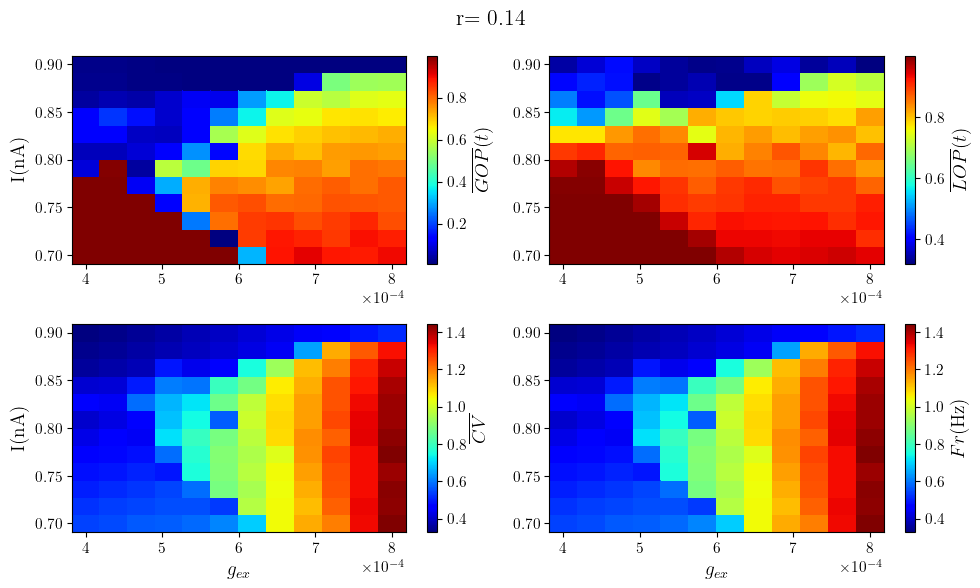

In [22]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,6))
fig.set_tight_layout(20)
fig.suptitle('r= 0.14')
tg, ig = np.meshgrid(axis_amp, axis_gex)
hm0 = ax[0][0].pcolor(ig, tg, teste_gop, cmap='jet')
cbar0 = fig.colorbar(hm0, ax=ax[0][0])#, cax=cax1, format=formater)
cbar0.set_label(r'$\overline{GOP}(t)$')

tg, ig = np.meshgrid(axis_amp, axis_gex)
hm1 = ax[0][1].pcolor(ig, tg, teste_lop, cmap='jet')
cbar1 = fig.colorbar(hm1, ax=ax[0][1])#, cax=cax1, format=formater)
cbar1.set_label(r'$\overline{LOP}(t)$')

tg, ig = np.meshgrid(axis_amp, axis_gex)
hm2 = ax[1][0].pcolor(ig, tg, teste_cv, cmap='jet')
cbar2 = fig.colorbar(hm2, ax=ax[1][0])#, cax=cax1, format=formater)
cbar2.set_label('$\overline{CV}$')

tg, ig = np.meshgrid(axis_amp, axis_gex)
hm3 = ax[1][1].pcolor(ig, tg, teste_cv, cmap='jet')
cbar3 = fig.colorbar(hm3, ax=ax[1][1])#, cax=cax1, format=formater)
cbar3.set_label('$Fr$(Hz)')

ax[0][0].set_ylabel('I(nA)')
ax[1][0].set_ylabel('I(nA)')
ax[1][0].set_xlabel('$g_{ex}$')
ax[1][1].set_xlabel('$g_{ex}$')
plt.savefig('../figures/Current_By_gex_means.png', dpi=600, bbox_inches='tight')
plt.show()

In [2]:
file = f'../data/v0_batch6/v0_batch0_data.pkl'
with open(file, 'rb') as f:
    data1 = pickle.load(f)

file = f'../data/v0_batch8/v0_batch0_data.pkl'
with open(file, 'rb') as f:
    data2 = pickle.load(f)

file = f'../data/v0_batch9/v0_batch0_data.pkl'
with open(file, 'rb') as f:
    data3 = pickle.load(f)

file = f'../data/v0_batch0/v0_batch0_data.pkl'
with open(file, 'rb') as f:
    data4 = pickle.load(f)

In [3]:
def plotRaster(t_phase_smp, t_peaks, gex, amp):
    fig, ax = plt.subplots(1,1, figsize=(10,3))
    fig.set_tight_layout(20)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.set_title('$g_{ex}='+f'{gex}$ S/cm²' + ' | '+'$I='+f'{amp}$ nA'+ '\n' , fontsize=14)
    ax.set_ylabel('$n$-ésimo Neurônio')
    ax.set_xlabel('Tempo (ms)')
    ax.set_ylim(0, len(t_peaks))
    ax.set_xlim(2001, t_phase_smp[-1])
    ax.set_title('$g_{ex}='+f'{gex}$ S/cm²' + ' | '+'$I='+f'{amp}$ nA')

    ax.eventplot(t_peaks, color='black', linewidths=2)
    # plt.savefig(file+f'_PlotRaster_{gex}_{amp}.png', dpi=600, bbox_inches='tight')
    plt.show()

In [4]:
data1['simConfig']['gex']

5e-07

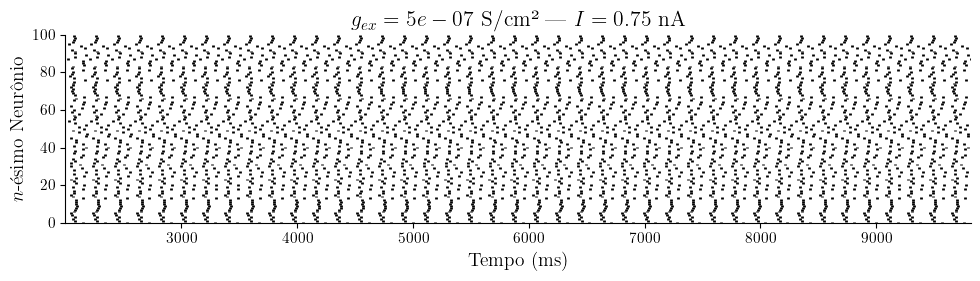

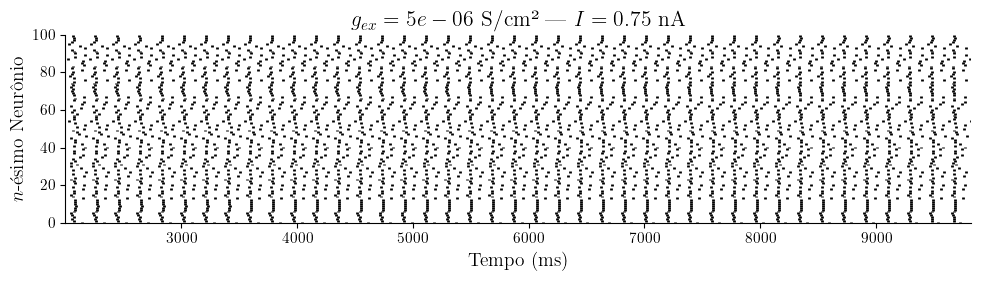

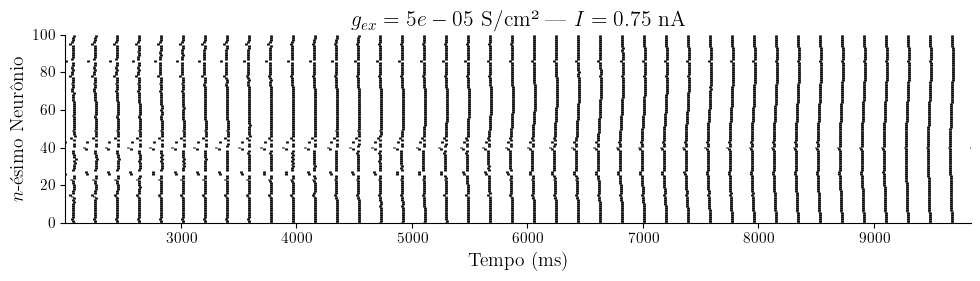

In [5]:
plotRaster(data1['t_phase'], data1['t_peaks'], data1['simConfig']['gex'], data1['simConfig']['IClamp0']['amp'])
plotRaster(data2['t_phase'], data2['t_peaks'], data2['simConfig']['gex'], data2['simConfig']['IClamp0']['amp'])
plotRaster(data3['t_phase'], data3['t_peaks'], data3['simConfig']['gex'], data3['simConfig']['IClamp0']['amp'])

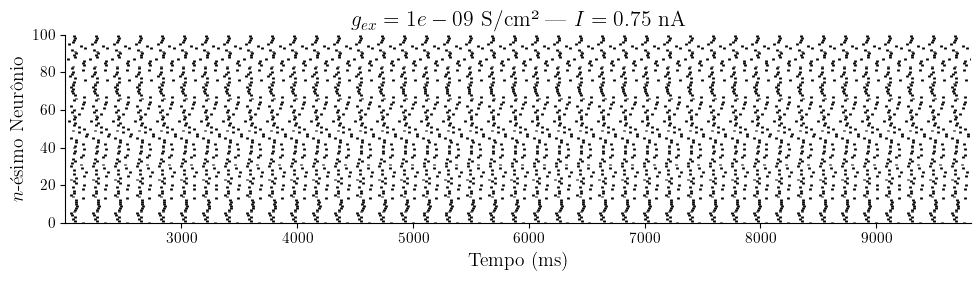

In [6]:
plotRaster(data4['t_phase'], data4['t_peaks'], data4['simConfig']['gex'], data4['simConfig']['IClamp0']['amp'])

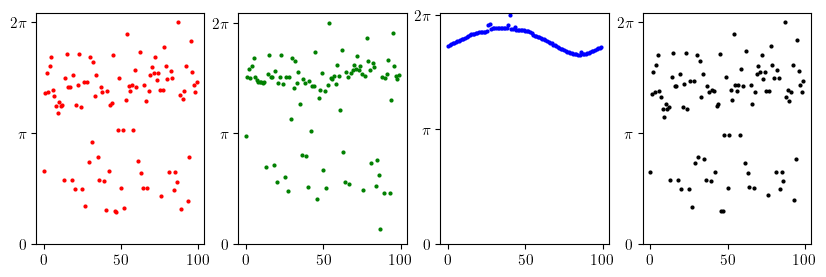

In [7]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(10,3))

ax[0].plot(data1['phases'][:,-1], 'ro', markersize=2)
ax[1].plot(data2['phases'][:,-1], 'go', markersize=2)
ax[2].plot(data3['phases'][:,-1], 'bo', markersize=2)
ax[3].plot(data4['phases'][:,-1], 'ko', markersize=2)

for axis in ax:
    axis.set_yticks([0, np.pi, 2*np.pi])
    axis.set_yticklabels(['0', '$\pi$', '$2 \pi$']) 
plt.show()

In [39]:
def plot_phase_metrics(data):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,2))
    ax[0].plot(np.arange(100), data['phases'][:,-100], 'ko', markersize=2, label='Estado dos elementos')

    ax[0].set_yticks([0, np.pi, 2*np.pi])
    ax[0].set_yticklabels(['0', '$\pi$', '$2 \pi$']) 

    ax[1].plot(np.arange(100), data['LOP_delta'][1].mean(axis=0), 'bo', markersize=2,  label='$\overline{LOP}(t)$')
    ax[1].hlines(y = data['LOP_delta'][1].mean(), xmin=0, xmax=100, color='green', label='$\overline{LOP}$')
    ax[1].hlines(y = data['GOP'][-100], xmin=0, xmax=100, color='darkorange', label='$GOP(t)$')
    ax[1].hlines(y = data['GOP'].mean(), xmin=0, xmax=100, color='red', label='$\overline{GOP}$')

    for axis in ax:
        axis.set_xlim(-0.1, 100.1)
        axis.set_xlabel('$n$')

    ax[0].set_title('Fases na ultima iteração', pad=20)
    ax[0].set_ylabel('$\phi_n$')
    ax[0].legend() # bbox_to_anchor=(1., 1.02)

    ax[1].set_title('Métricas espaciais', pad=20)
    ax[1].set_ylabel('Valor')
    ax[1].set_ylim(-0.05,1.05)
    ax[1].legend(bbox_to_anchor=(1., 1.02)) # 

    plt.show()


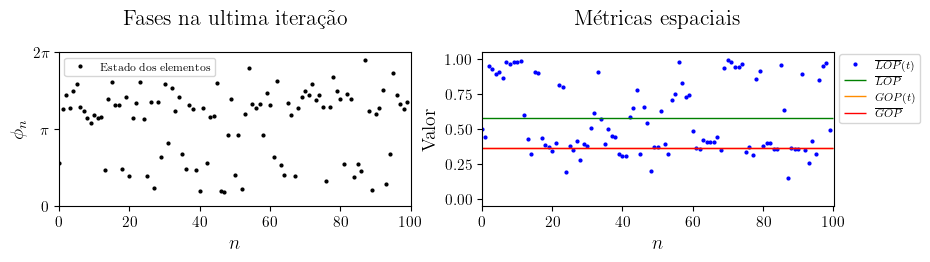

In [40]:
plot_phase_metrics(data1)

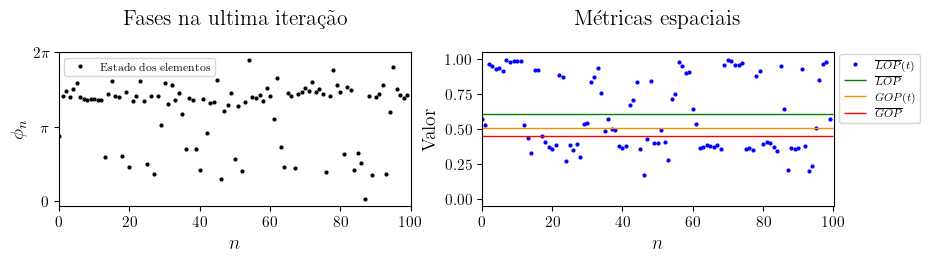

In [41]:
plot_phase_metrics(data2)

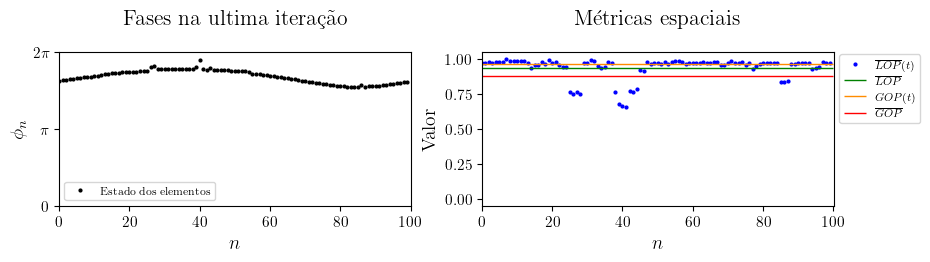

In [42]:
plot_phase_metrics(data3)

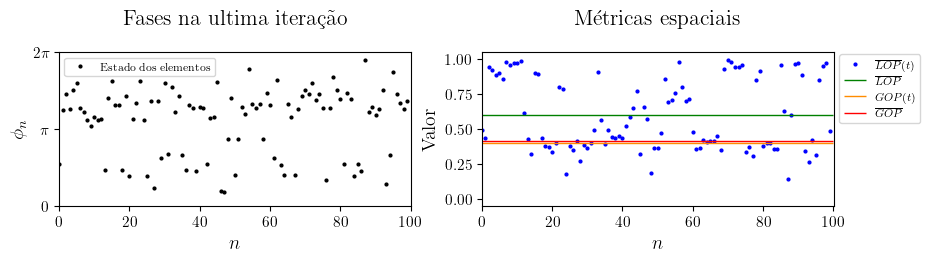

In [43]:
plot_phase_metrics(data4)

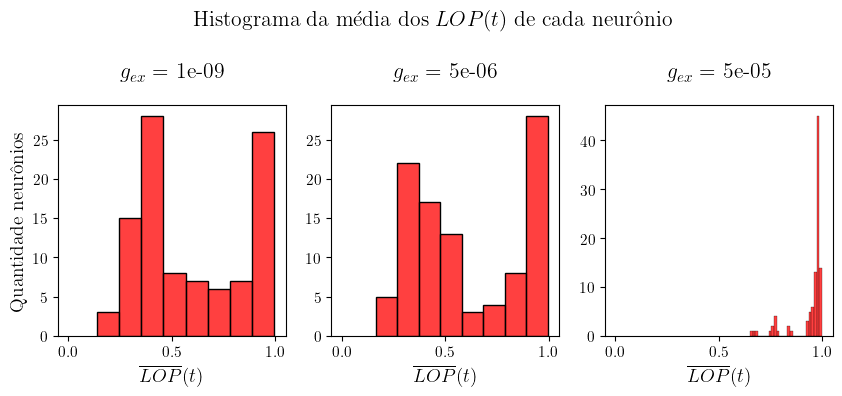

In [31]:
import seaborn as sns 
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10,3), sharex=True)
fig.suptitle('Histograma da média dos $LOP(t)$ de cada neurônio', y=1.2)
for axis in ax:
    axis.set_xlim(-0.05, 1.05)
    axis.set_xlabel(r'$\overline{LOP}(t)$')
    axis.set_ylabel(' ')
sns.histplot(data4['LOP_delta'][1][2000:,:].mean(axis=0), ax=ax[0], color='red')
sns.histplot(data2['LOP_delta'][1][2000:,:].mean(axis=0), ax=ax[1], color='red')
sns.histplot(data3['LOP_delta'][1][2000:,:].mean(axis=0), ax=ax[2], color='red')
ax[0].set_ylabel('Quantidade neurônios')
ax[0].set_title('$g_{ex}=$ '+f"{data4['simConfig']['gex']}",pad=20)
ax[1].set_title('$g_{ex}=$ '+f"{data2['simConfig']['gex']}",pad=20)
ax[2].set_title('$g_{ex}=$ '+f"{data3['simConfig']['gex']}",pad=20)
plt.show()

In [36]:
def plot_LOP(t_phase_smp, lop, vizinhos):
    from matplotlib.colors import ListedColormap
    colors = ["darkorange", "gold", "lawngreen", "lightseagreen","darkgreen"]
    cmap_LOP = ListedColormap(colors)

    fig, ax2 = plt.subplots(ncols=1, nrows=1, figsize=(8,3),sharex=True)
    fig.set_tight_layout(20)
    # fig.suptitle('$g_{ex}='+f'{gex}$ S/cm²' + ' | '+'$I='+f'{amp}$ nA'+ '\n' +f'PopRate $={popRates:.2f}$Hz'+ ' | '+f'$r$: {float(r)}', fontsize=14)
    n_neurons = np.arange(lop.shape[1])
    t = t_phase_smp
    tg, ig = np.meshgrid(n_neurons, t)
    hm2 = ax2.pcolor(ig, tg, lop, cmap=cmap_LOP, vmax=1.0, vmin=0)#cmap_LOP)

    cbar2= plt.colorbar(hm2, ax=ax2, ticks=[0, 1])
    cbar2.ax.set_yticklabels(['0', '1,0']) 
    cbar2.set_label('LOP$(t)$')
    ax2.set_title('$\delta='+f'{vizinhos}'+'$')
    ax2.set_ylabel('$n$ neurônio')
    ax2.set_ylim(0,len(n_neurons))
    ax2.set_xlabel('Tempo (ms)')
    ax2.set_xlim(t_phase_smp[1000], t_phase_smp[-100])
    # plt.savefig(file+f'_PlotLOP_{gex}_{amp}_{vizinhos}.png', dpi=600, bbox_inches='tight')
    plt.show()

KeyboardInterrupt: 

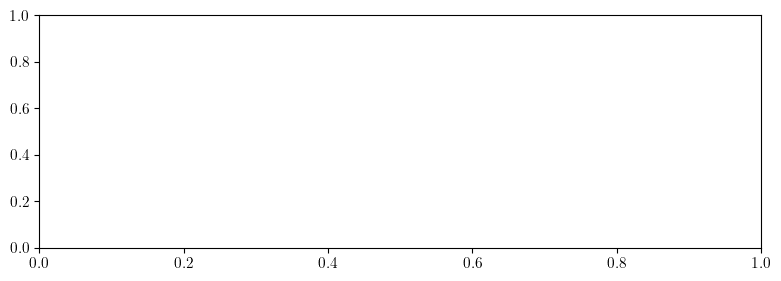

In [37]:
plot_LOP(data1['t_phase'], data1['LOP_delta'][1],1)
plot_LOP(data2['t_phase'], data2['LOP_delta'][1],1)
plot_LOP(data3['t_phase'], data3['LOP_delta'][1],1)

In [12]:
t_data, v_data = get_numpy(data)
v_data.shape

(200, 60001)

In [11]:
v_data[:, 4000:60000].shape

(200, 56000)

## Phase of Neuron 

$$\phi_k(t) = 2 \pi m + 2 \pi \frac{t - t_{k,m}}{t_{k,m+1} - t_{k, m}}$$

In [2]:
def find_peaks(t_arr, v_arr, only_id=False):
    """
    Encontra os picos em um sinal de forma de onda.

    Args:
        t_arr (array-like): Uma matriz de tempos correspondentes aos valores do sinal de forma de onda.
        v_arr (array-like): Uma matriz de valores do sinal de forma de onda.
        only_id (bool, optional): Indica se apenas os IDs dos picos devem ser retornados. O padrão é False.

    Returns:
        tuple or numpy.ndarray: Se only_id for False, retorna uma tupla contendo os IDs dos picos, tempos correspondentes e valores correspondentes. Se only_id for True, retorna apenas os IDs dos picos.
    """
    peaks_id, _ = scipy.signal.find_peaks(v_arr, height=0)
    t = t_arr[peaks_id]
    v = v_arr[peaks_id]
    if only_id:
        peaks_id
    else:
        return peaks_id, t, v

def phase_of_v(t_sample, v_sample, return_peaks=False):
    """
    Calcula as fases de um sinal de forma de onda em relação aos picos.

    Args:
        t_sample (array-like): Uma matriz de tempos correspondentes aos valores do sinal de forma de onda.
        v_sample (array-like): Uma matriz de valores do sinal de forma de onda.

    Returns:
        numpy.ndarray: Uma matriz contendo as fases calculadas para cada neurônio em relação aos picos.

    Raises:
        None
    """
    peaksmat, t_peaks = [], [],  # listas para encontrar id e tempo dos picos
    for v in v_sample:
        peaks_id, t_peak, _ = find_peaks(t_sample, v)
        peaksmat.append(peaks_id)
        t_peaks.append(t_peak)
    
    id_first_spk = min([min(peak) for peak in peaksmat]) # id primeiro spk
    id_last_spk = min([max(peak) for peak in peaksmat]) # id do primeiro dos ultimos spk 

    t_range = t_sample[id_first_spk:id_last_spk]  # tempo onde a phase é definida
    phi = lambda t, t0, t1 : 2*np.pi*(t-t0)/(t1 - t0)  # calcular fase
    phases = np.zeros((len(peaksmat), len(t_range)))  # phases dos n neurônios

    # para cada id do pico n-esimo neuronio
    for n, peak in enumerate(peaksmat):
        # para cada ISI do neurônio
        for t0, t1 in zip(t_sample[peak][:], t_sample[peak][1:]):
            # para cada tempo i onde definimos a fase:
            for i, t in enumerate(t_range):
                if t0 < t <t1:
                    # calcula a fase phi e adiciona no array
                    phases[n,i] = phi(t,t0,t1)
    if return_peaks:
        return t_range, phases, peaksmat, t_peaks, id_first_spk, id_last_spk
    else:    
        return t_range, phases

# Global Order Parameter (GOP)

$Z(t) = \frac{1}{N} \Big|\sum_{j}^{N} \text{exp}\big(2 \pi i \phi_j(t)\big)\Big|,$

In [3]:
def kuramoto_param_global_order(spatial_phase_arr):
    """
    Calculates the global order parameter of Kuramoto for a set of spatial phases.

    Args:
        spatial_phase_arr (numpy.ndarray): Array representing the spatial phase distribution of neurons.

    Returns:
        float: Value of the global order parameter of Kuramoto.

    """
    n = len(spatial_phase_arr)
    somatorio = 0
    for j in range(n):
        j = j % n
        somatorio += np.exp(complex(0, spatial_phase_arr[j]))
    gop = np.abs(somatorio) / n
    return gop


## Local Order Parameter (LOP)

$$Z_j (t) = \Big|\frac{1}{2\delta} \sum_{j-k \le \delta}^{j+k} \text{exp}[i \phi_{k}(t)]\Big|,$$

such that $\delta$ is the number of neighbors in one direction and $0\le k <0.5$

In [4]:
def kuramoto_param_local_order(spatial_phase_arr, k):
    """
    Calculates the Kuramoto parameter order for a given spatial phase distribution.

    Args:
        spatial_phase_arr (numpy.ndarray): Array representing the spatial phase distribution of neurons.
        k (int): Number of neighboring neurons to consider.

    Returns:
        numpy.ndarray: Array of Kuramoto parameter order values for each neuron.
    """
    n = len(spatial_phase_arr)
    delta = int(k/2)  # neurons in one direction
    lop = np.zeros_like(spatial_phase_arr)

    for i in range(n):
        somatorio = 0
        for vizinhos in range(i - delta, i + delta + 1):
            j = vizinhos % n
            somatorio += np.exp(complex(0, spatial_phase_arr[j]))
        lop[i] = np.abs(somatorio / (int(2*delta)+1))
    return lop

## Recurrence Analysis

In [5]:
import numpy as np
from pyunicorn.timeseries import RecurrencePlot, RecurrenceNetwork



In [43]:
t_peaks = data['t_peaks']
t_phase = data['t_phase']
phases = data['phases']
id_first_spk = data['id_first_spk']
id_last_spk = data['id_last_spk']


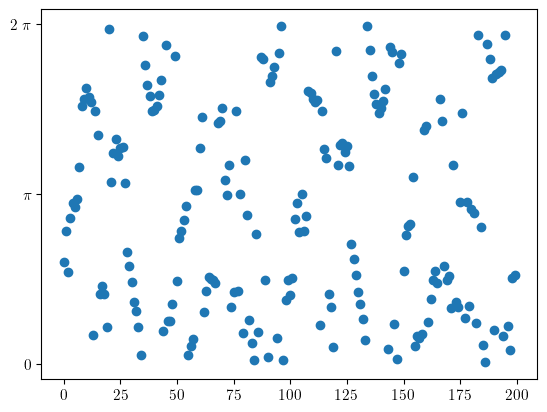

In [48]:
phases_sample = data['phases'][:, -5000]
plt.figure()
plt.scatter(y = phases_sample, x = np.arange(200))

plt.yticks([0, np.pi, 2*np.pi], labels=['0','$\pi$','2 $\pi$'])
plt.show()

In [70]:
import numpy as np
from pyunicorn.timeseries import RecurrencePlot, RecurrenceNetwork

DIM = 1  # Embedding dimension
TAU = 0  # Embedding delay

#  Settings for the recurrence plot
EPS = 0.05  # Fixed threshold
RR = 0.05   # Fixed recurrence rate
# Distance metric in phase space ->
# Possible choices ("manhattan","euclidean","supremum")
METRIC = "euclidean"

time_series = phases_sample

rp = RecurrencePlot(time_series, dim=DIM, tau=TAU, metric=METRIC,
                    normalize=False, threshold=EPS)

Calculating recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...


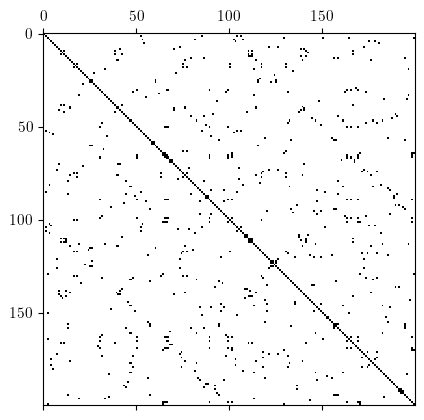

In [71]:
plt.matshow(rp.recurrence_matrix(), cmap='binary')

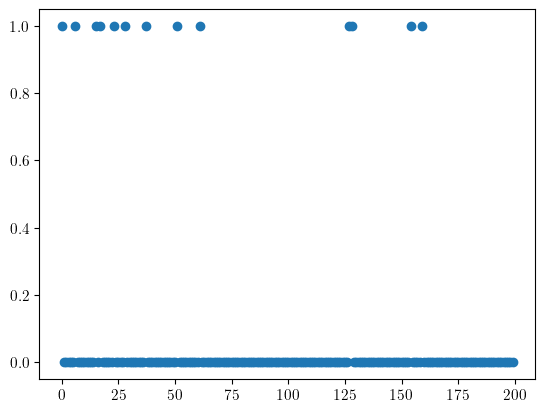

In [78]:
S = [0 if s > 0 else 1 for s in np.sum(rp.recurrence_matrix(), axis=0) - 1]

plt.scatter(x = np.arange(200), y = S)

In [79]:
np.sum(S)

13

# 3) Chimera States
find the network's parameters where the chimera state is visible.

param global and local order of kuramoto

heatmap of phase $m^{th}$ neuron

# 4) Heatmaps of parameters

standart deviation and mean of chemra's parameters .